# Breast Cancer Classification using SVM (balanced data)

### Import libraries

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
import os, shutil
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import svm, metrics
from sklearn.model_selection import learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.utils.multiclass import unique_labels

### Load data

In [128]:
img_width = 224
img_height = 224
batch_size = 8

def loading(HEIGHT = img_height, WIDTH = img_width,
BATCH_SIZE = batch_size, VALIDATION_SPLIT = 0.3,
ROT_RANGE = 90, H_FLIP = True, SHEAR_RANGE = 0.2,
ZOOM_RANGE = 0.2, V_FLIP = True):

    TRAIN_DIR = "C:/Users/Abdullah Abid/Desktop/Project/BreakHis Data"
    train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=ROT_RANGE,
    horizontal_flip=H_FLIP,
    shear_range=SHEAR_RANGE,
    zoom_range =ZOOM_RANGE,
    vertical_flip=V_FLIP,
    validation_split=VALIDATION_SPLIT
    )

    train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    subset = 'training',
                                                    class_mode='sparse')
    validation_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size = (HEIGHT, WIDTH),
                                                        batch_size=BATCH_SIZE,
                                                        subset = 'validation',
                                                        class_mode='sparse')
    return train_generator, validation_generator

In [129]:
%%time
train_generator, validation_generator = loading()

Found 28000 images belonging to 8 classes.
Found 12000 images belonging to 8 classes.
Wall time: 2.42 s


### SVM classifier

In [130]:
clf = SGDClassifier(loss="hinge", penalty="l2")

In [131]:
%%time

count = 0
for inputs_batch, labels_batch in train_generator:
    count = count + 1
    X_train = []
    y_train = []
    for i in range(0, batch_size):
        X_train.append(inputs_batch[i].flatten())
        y_train.append(labels_batch[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(int)
    clf.partial_fit(X_train, y_train, classes=np.unique(train_generator.classes))
    if count * batch_size >= train_generator.n:
        break

Wall time: 19min 30s


In [132]:
%%time

y_test = []
y_pred = []
count = 0

for inputs_batch, labels_batch in validation_generator:
    count = count + 1
    X_test = []
    for i in range(0, batch_size):
        X_test.append(inputs_batch[i].flatten())
        y_test.append(labels_batch[i])
    X_test = np.array(X_test)
    y_pred.append(clf.predict(X_test))
    if count * batch_size >= validation_generator.n:
        break
        
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_pred = np.array(y_pred)
y_pred = y_pred.flatten()

Wall time: 7min 21s


### Classification report

In [133]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1500
           1       0.87      0.04      0.08      1500
           2       0.60      0.00      0.00      1500
           3       0.00      0.00      0.00      1500
           4       0.00      0.00      0.00      1500
           5       0.13      0.53      0.21      1500
           6       0.15      0.58      0.24      1500
           7       0.00      0.00      0.00      1500

    accuracy                           0.15     12000
   macro avg       0.22      0.15      0.07     12000
weighted avg       0.22      0.15      0.07     12000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion matrix

In [187]:
# code reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [188]:
class_names = []

for key in train_generator.class_indices.keys():
    class_names.append(key)

class_names = np.array(class_names)

Confusion matrix, without normalization
[[   0    0    0    0    0  484 1016    0]
 [   0   65    1    0    9 1193  232    0]
 [   0    0    3    0    0  478 1019    0]
 [   0    0    0    0    3  927  570    0]
 [   0    0    0    2    0  935  563    0]
 [   0    9    1    1    5  801  683    0]
 [   0    0    0    0    0  628  872    0]
 [   0    1    0    0    0  562  937    0]]


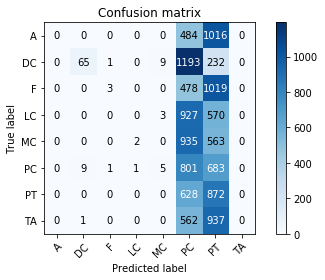

In [195]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix')
plt.show()

Normalized confusion matrix
[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.23e-01 6.77e-01 0.00e+00]
 [0.00e+00 4.33e-02 6.67e-04 0.00e+00 6.00e-03 7.95e-01 1.55e-01 0.00e+00]
 [0.00e+00 0.00e+00 2.00e-03 0.00e+00 0.00e+00 3.19e-01 6.79e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e-03 6.18e-01 3.80e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.33e-03 0.00e+00 6.23e-01 3.75e-01 0.00e+00]
 [0.00e+00 6.00e-03 6.67e-04 6.67e-04 3.33e-03 5.34e-01 4.55e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.19e-01 5.81e-01 0.00e+00]
 [0.00e+00 6.67e-04 0.00e+00 0.00e+00 0.00e+00 3.75e-01 6.25e-01 0.00e+00]]


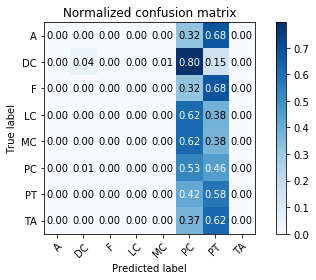

In [193]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()